In [26]:
import networkx as nx
import numpy as np
import scipy as sp
import time
import seaborn as sns
from seaborn import heatmap
import pickle
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy.random import default_rng
rng = default_rng(42)  # Create a random number generator
from scipy.spatial.distance import pdist, squareform
from scipy.sparse import coo_matrix
from gtda.graphs import GraphGeodesicDistance
from gtda.homology import VietorisRipsPersistence, SparseRipsPersistence, FlagserPersistence
from gtda.diagrams import Scaler, Filtering, PersistenceEntropy, BettiCurve, PairwiseDistance
from gtda.graphs import KNeighborsGraph, GraphGeodesicDistance
from igraph import Graph
from IPython.display import SVG, display
# gtda plotting functions
from gtda.plotting import plot_heatmap
from scipy.stats import skew
import scipy.stats as stats
from scipy.stats import kurtosis
from scipy.stats import linregress


sns.set(style='ticks', context='poster',
        font_scale=2.4, rc={'figure.figsize': (14, 10)})
font = {'weight': 'bold'}
mpl.rc('font', **font)



In [37]:
def construct_network(distance, threshold):
    # Constructing a network based on the distance matrix.
    # Return the adjacency matrix of the resulting network.

    a = 1.*(distance < threshold)
    a = a - np.diag(np.diag(a))
    return a


def random_distance_matrix(distance):
    # Random permutation of the distance matrix as the null model.
    # The upper triangular part is randomly permuted.

    d3 = distance
    n_g = d3.shape[0]
    d3_triu = np.triu(d3, 1)
    dist_flat = d3_triu.flatten()
    dist_flat = dist_flat[dist_flat > 0]
    np.random.shuffle(dist_flat)

    d_rand = np.zeros((n_g, n_g))
    d_rand[np.triu_indices(n_g, 1)] = dist_flat
    d_rand = d_rand + d_rand.T
    return d_rand

def calculate_threshold(distance, cutoff):
    # Determine the threshold for constructing the network.
    # The threshold is defined as the average of distances to n-th (cutoff) closest neighbor

    sorted_data = np.sort(distance, 1)
    threshold = np.average(sorted_data[:, cutoff])
    return threshold

def percolation(d):
    G = nx.Graph()
    R_list = []         # Size of the largest cluster
    R2_list = []        # Size of the second largest cluster
    ns_mean = []        # number of connected cluster
    s_mean_list = []    # average size of small connected clusters (smaller than the second largest one)
    r_list = []         # threshold 
    Y2_list = []        # inverse participation ratio
    d_max = np.max(np.max(d))
    n = d.shape[0]
    for r in np.linspace(0, d_max, 50):
        print(r)
        a = 1.*(d < r)
        a = a-np.diag(np.diag(a))
        k = sum(a)
        G = nx.from_numpy_array(a)
        c_sorted = sorted(nx.connected_components(G), key=len, reverse=True)
        s_mean = 0
        R = len(c_sorted[0])
        R2 = len(c_sorted[1]) if len(c_sorted) > 1 else 0
        s2_mean = R**2+R2**2
        for nc in range(2, len(c_sorted)):
            s = len(c_sorted[nc])
            s_mean = s_mean+s
            s2_mean = s2_mean+s**2
        R_list.append(R/n)
        R2_list.append(R2/n)
        ns_mean.append(len(c_sorted))
        norm = (len(c_sorted)-2)
        s_mean_list.append(s_mean/(norm+1*(norm == 0)))
        Y2_list.append((s2_mean/((s_mean+R+R2)**2)))
        r_list.append(r)
    return r_list,R_list, R2_list,ns_mean,s_mean_list,Y2_list



# Construct IsingNet
The provided distance matrices contain 300 equilibrium configurations (300 nodes) and the entries are Euclidean distances between configuration vectors. 
The IsingNet is constructed from the distance matrix. A pair of nodes is connected if the distance between them is smaller than a threshold. Here the threshold is defined as the average of distances to 5-th closest neighbors.

In [3]:
cutoff = 5 # average 5-th closest neighbor distance
T = 2.12 # temperature

d = np.load("distance_"+str(T)+".npy")
d_rand = random_distance_matrix(d)  # corresponding null model

threshold = calculate_threshold(d, cutoff)

a = construct_network(d, threshold) # IsingNet
a_rand = construct_network(d_rand, threshold)   # corresponding null model (an Erdos-Renyi network of the same average degree)

## Percolation

0.0
1.5760599654128833
3.1521199308257666
4.72817989623865
6.304239861651533
7.880299827064416
9.4563597924773
11.032419757890183
12.608479723303066
14.18453968871595
15.760599654128832
17.336659619541717
18.9127195849546
20.488779550367482
22.064839515780367
23.640899481193248
25.216959446606133
26.793019412019017
28.3690793774319
29.945139342844783
31.521199308257664
33.09725927367055
34.67331923908343
36.249379204496314
37.8254391699092
39.401499135322084
40.977559100734965
42.553619066147846
44.129679031560734
45.705738996973615
47.281798962386496
48.857858927799384
50.433918893212265
52.009978858625146
53.586038824038035
55.162098789450916
56.7381587548638
58.314218720276685
59.890278685689566
61.46633865110245
63.04239861651533
64.61845858192821
66.1945185473411
67.77057851275399
69.34663847816687
70.92269844357975
72.49875840899263
74.07481837440551
75.6508783398184
77.22693830523129


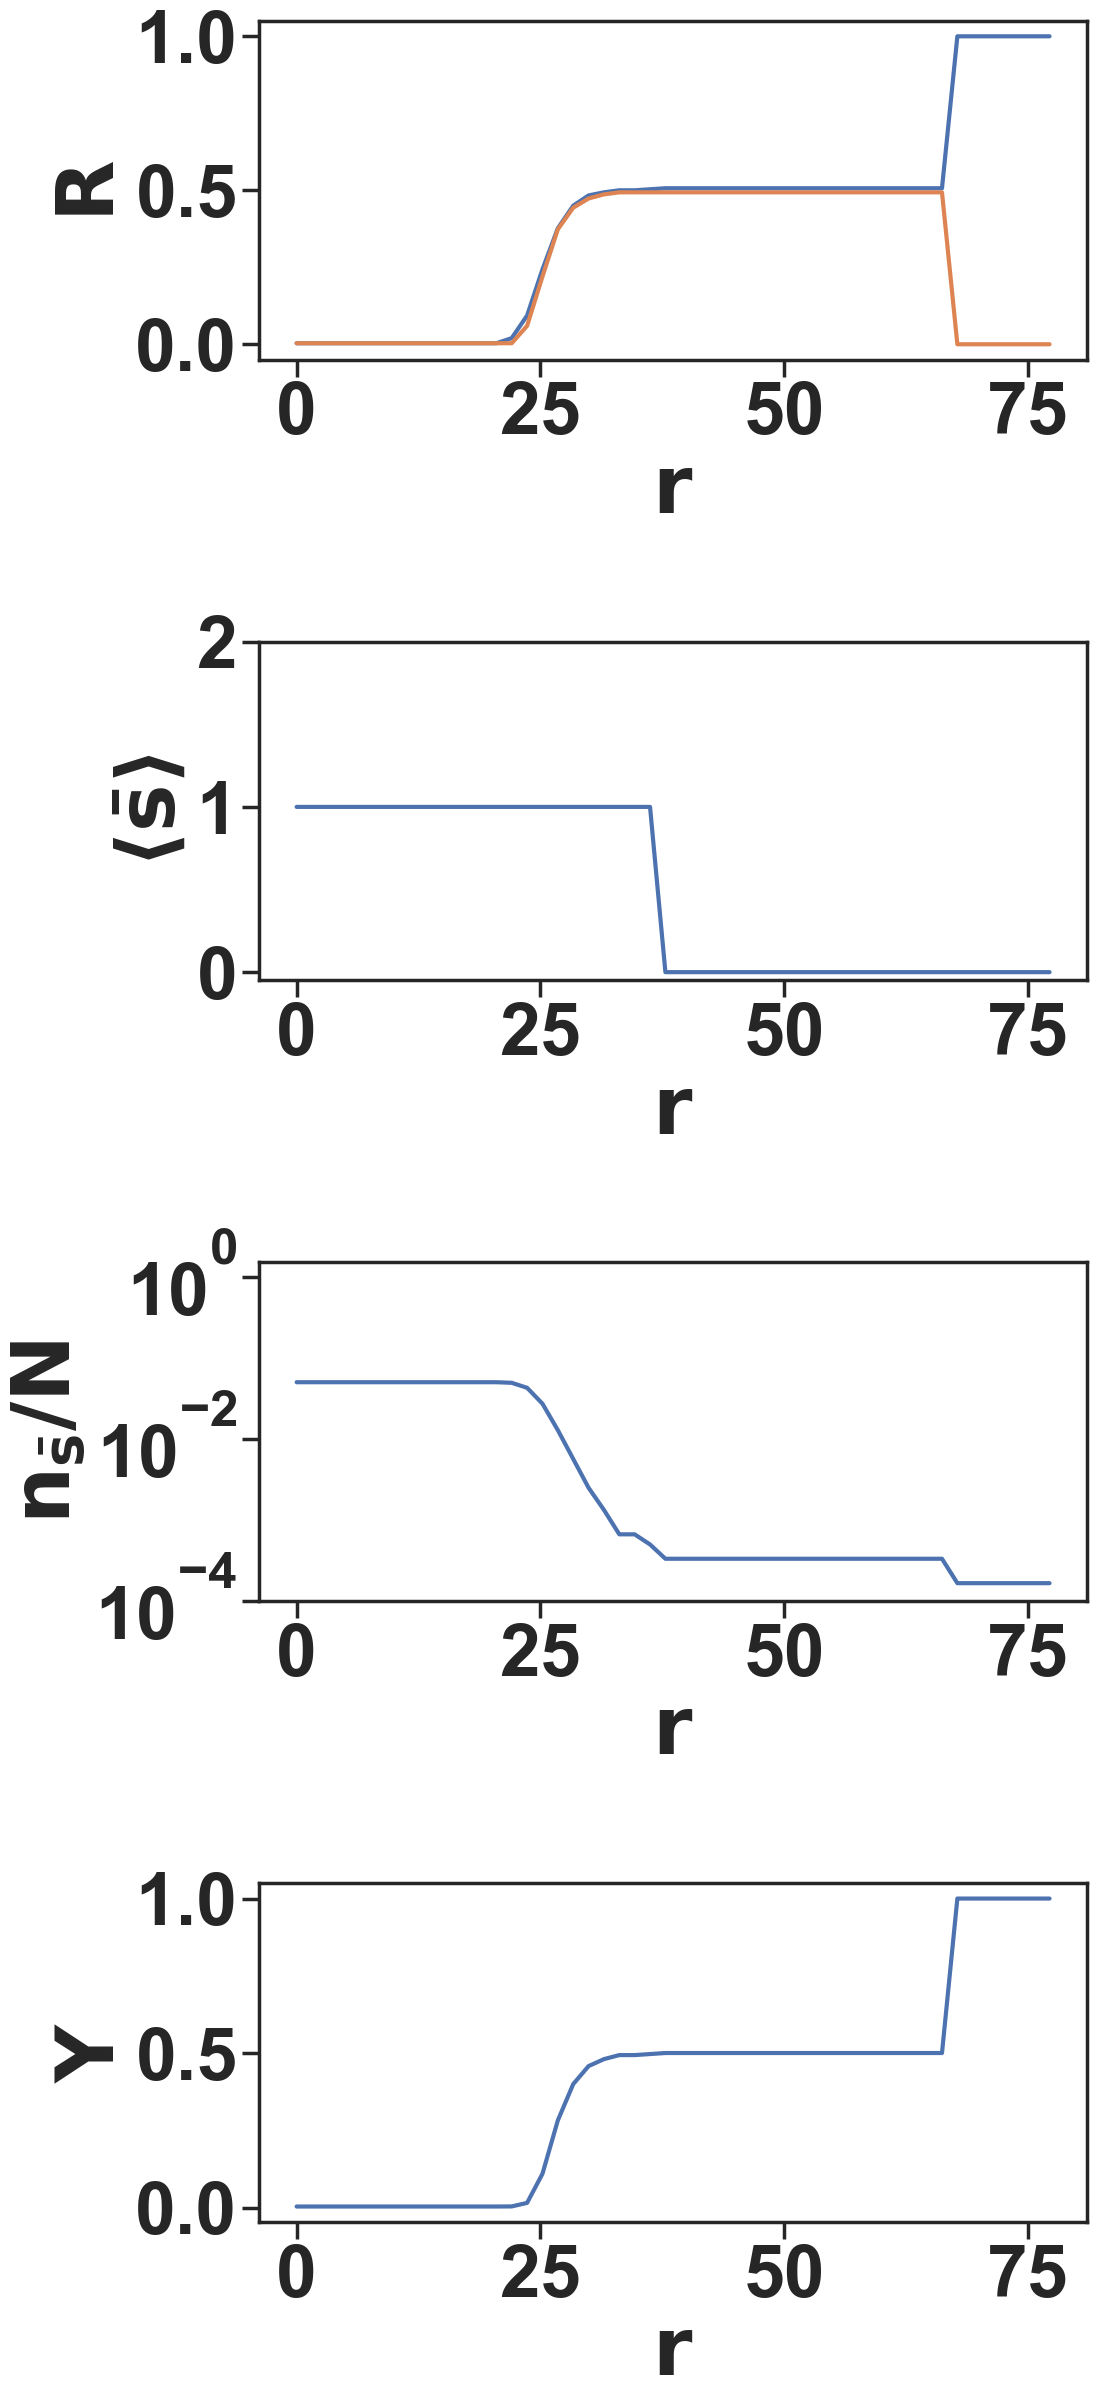

In [36]:
r_list, R_list, R2_list, ns_mean, s_mean_list, Y2_list = percolation(d)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4)
fig.set_size_inches(12.5, 25.5)
ax1.plot(r_list, R_list)
ax1.plot(r_list, R2_list)
ax1.set(xlabel=r'$\bf r$', ylabel=r'$\bf R$')
ax1.set_xticks([0, 25, 50 ,75])
ax1.set_xticklabels(['0', '25', '50', '75'])
ax1.set_yticks([0, 0.5, 1])
ax1.set_yticklabels(['0.0', '0.5', '1.0'])

ax2.plot(r_list, s_mean_list)
ax2.set(xlabel=r'$\bf r$', ylabel=r"$\bf \langle \bar{s} \rangle$")
ax2.set_xticks([0, 25, 50 ,75])
ax2.set_xticklabels(['0', '25', '50', '75'])
ax2.set_yticks([0, 1, 2])
ax2.set_yticklabels(['0', '1', '2'])

ax3.plot(r_list, np.array(ns_mean)/6000)
ax3.set(xlabel=r'$\bf r$', ylabel=r'$\bf n_{\bar{s}}/N$')
ax3.set_xticks([0, 25, 50 ,75])
ax3.set_xticklabels(['0', '25', '50', '75'])
ax3.set_yticks([1, 0.01, 0.0001])
ax3.set_yticklabels(['$10^0$', '$10^{-2}$', '$10^{-4}$'])
ax3.set_ylim(10**(-4), 1.5)
ax3.set_yscale('log')

ax4.plot(r_list, Y2_list)
ax4.set(xlabel=r'$\bf r$', ylabel=r'$\bf Y$')
ax4.set_xticks([0, 25, 50 ,75])
ax4.set_xticklabels(['0', '25', '50', '75'])
ax4.set_yticks([0, 0.5, 1])
ax4.set_yticklabels(['0.0', '0.5', '1.0'])
plt.tight_layout()

0.0
1.5760599654128833
3.1521199308257666
4.72817989623865
6.304239861651533
7.880299827064416
9.4563597924773
11.032419757890183
12.608479723303066
14.18453968871595
15.760599654128832
17.336659619541717
18.9127195849546
20.488779550367482
22.064839515780367
23.640899481193248
25.216959446606133
26.793019412019017
28.3690793774319
29.945139342844783
31.521199308257664
33.09725927367055
34.67331923908343
36.249379204496314
37.8254391699092
39.401499135322084
40.977559100734965
42.553619066147846
44.129679031560734
45.705738996973615
47.281798962386496
48.857858927799384
50.433918893212265
52.009978858625146
53.586038824038035
55.162098789450916
56.7381587548638
58.314218720276685
59.890278685689566
61.46633865110245
63.04239861651533
64.61845858192821
66.1945185473411
67.77057851275399
69.34663847816687
70.92269844357975
72.49875840899263
74.07481837440551
75.6508783398184
77.22693830523129


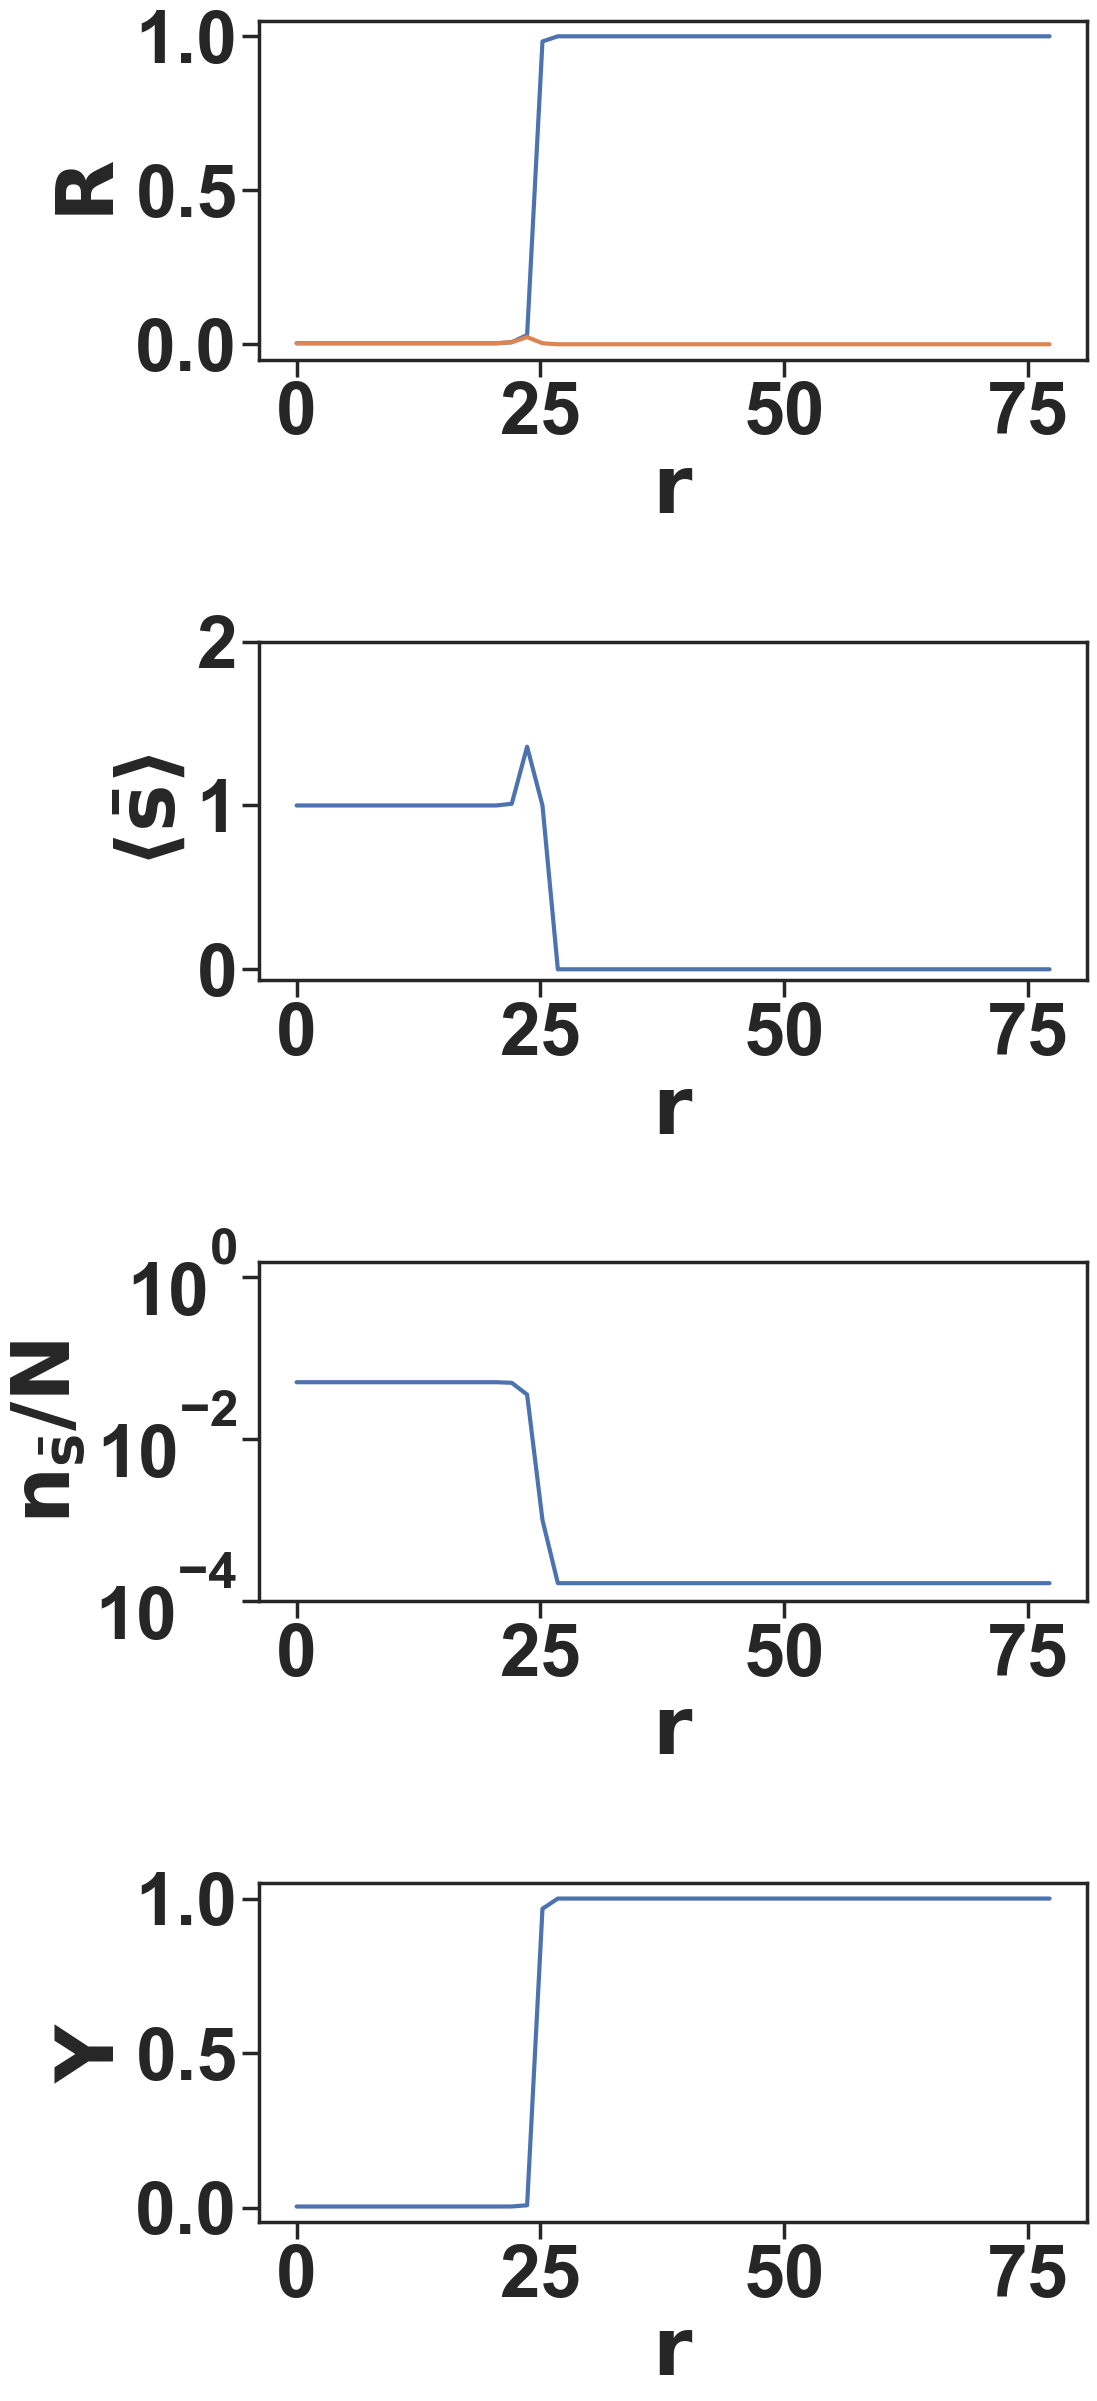

In [38]:
r_list, R_list, R2_list, ns_mean, s_mean_list, Y2_list = percolation(d_rand)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4)
fig.set_size_inches(12.5, 25.5)
ax1.plot(r_list, R_list)
ax1.plot(r_list, R2_list)
ax1.set(xlabel=r'$\bf r$', ylabel=r'$\bf R$')
ax1.set_xticks([0, 25, 50 ,75])
ax1.set_xticklabels(['0', '25', '50', '75'])
ax1.set_yticks([0, 0.5, 1])
ax1.set_yticklabels(['0.0', '0.5', '1.0'])

ax2.plot(r_list, s_mean_list)
ax2.set(xlabel=r'$\bf r$', ylabel=r"$\bf \langle \bar{s} \rangle$")
ax2.set_xticks([0, 25, 50 ,75])
ax2.set_xticklabels(['0', '25', '50', '75'])
ax2.set_yticks([0, 1, 2])
ax2.set_yticklabels(['0', '1', '2'])

ax3.plot(r_list, np.array(ns_mean)/6000)
ax3.set(xlabel=r'$\bf r$', ylabel=r'$\bf n_{\bar{s}}/N$')
ax3.set_xticks([0, 25, 50 ,75])
ax3.set_xticklabels(['0', '25', '50', '75'])
ax3.set_yticks([1, 0.01, 0.0001])
ax3.set_yticklabels(['$10^0$', '$10^{-2}$', '$10^{-4}$'])
ax3.set_ylim(10**(-4), 1.5)
ax3.set_yscale('log')

ax4.plot(r_list, Y2_list)
ax4.set(xlabel=r'$\bf r$', ylabel=r'$\bf Y$')
ax4.set_xticks([0, 25, 50 ,75])
ax4.set_xticklabels(['0', '25', '50', '75'])
ax4.set_yticks([0, 0.5, 1])
ax4.set_yticklabels(['0.0', '0.5', '1.0'])
plt.tight_layout()

## Degree and strength

Calcualte degree and strength, and their second moments


In [4]:
G = nx.Graph()
G = nx.from_numpy_array(a)
G_rand = nx.Graph();
G_rand = nx.from_numpy_array(a_rand)

# Add weights

nx.set_edge_attributes(G, {edge: 1/d[edge[0],edge[1]] for edge in G.edges()}, 'weight')
nx.set_edge_attributes(G_rand, {edge: 1/d_rand[edge[0],edge[1]] for edge in G_rand.edges()}, 'weight')

# IsingNet
strength=np.array(list(G.degree(G, weight="weight")))
degree=np.array(list(G.degree(G, weight=None)))
strength = strength[:, 1]
degree = degree[:, 1]

# Null model
strength_rand=np.array(list(G_rand.degree(G_rand, weight="weight")))
degree_rand=np.array(list(G_rand.degree(G_rand, weight=None)))
strength_rand = strength_rand[:, 1]
degree_rand = degree_rand[:, 1]

# Average
k_avg = np.average(degree)
s_avg = np.average(strength)
k_avg_rand = np.average(degree_rand)
s_avg_rand = np.average(strength_rand)

# Second moment
k_sq_avg = np.average(degree ** 2)
s_sq_avg = np.average(strength ** 2)
k_sq_avg_rand = np.average(degree_rand ** 2)
s_sq_avg_rand = np.average(strength_rand ** 2)


## Degree correlation
### Nearest neighbor degree (knn)

In [14]:

G = nx.Graph()
G = nx.from_numpy_array(a)

G_rand=nx.Graph();
G_rand = nx.from_numpy_array(a_rand)

k=nx.degree(G)
k_rand = nx.degree(G_rand)

knn=nx.average_neighbor_degree(G)
knn_rand=nx.average_neighbor_degree(G_rand)


k=np.array(list(k))
k=k[:,1]
k_rand=np.array(list(k_rand))
k_rand=k_rand[:,1]

knn=np.array(list(knn.values()))
knn_rand=np.array(list(knn_rand.values()))


Text(0, 0.5, '$\\bf k_{nn}$')

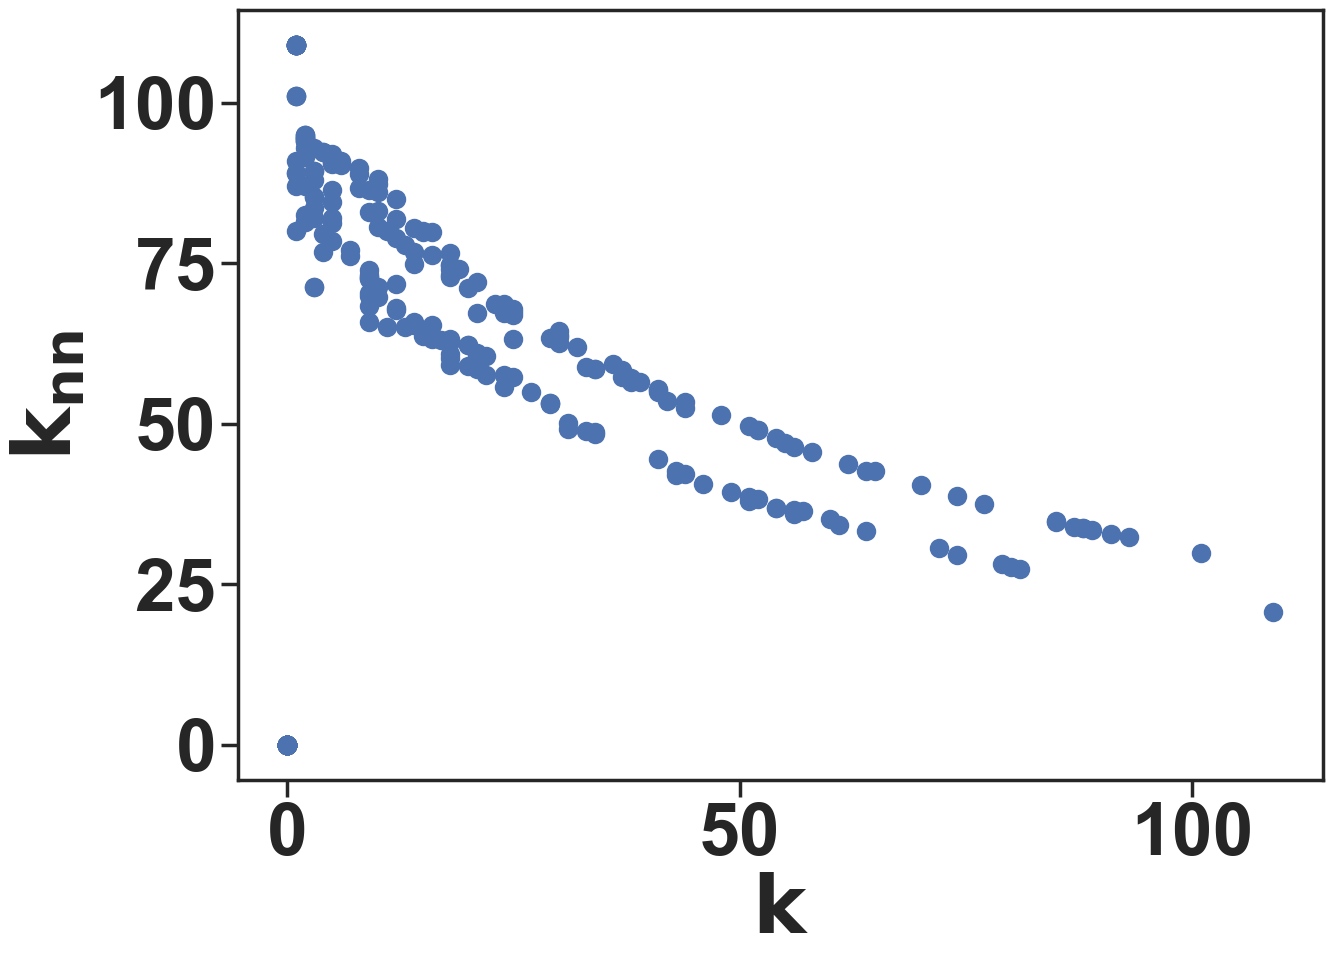

In [16]:
# knn versus k on IsingNet

plt.scatter(k,knn)
plt.xlabel(r"$\bf k$")
plt.ylabel(r"$\bf k_{nn}$")

Text(0, 0.5, '$\\bf k_{nn}$')

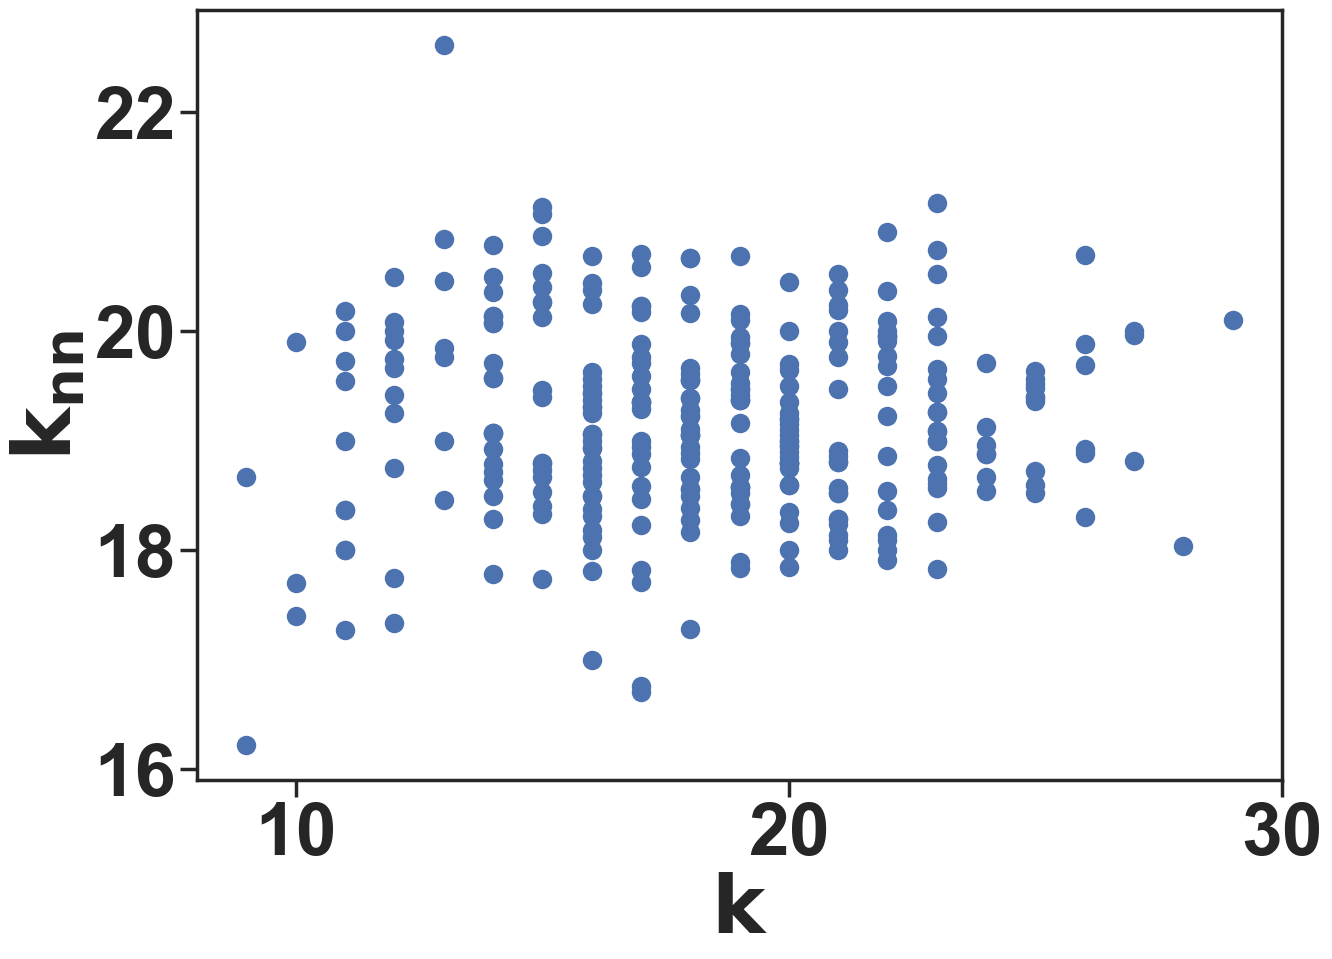

In [15]:
# knn versus k on null model

plt.scatter(k_rand, knn_rand)
plt.xlabel(r"$\bf k$")
plt.ylabel(r"$\bf k_{nn}$")


### Pearson correlation coefficient and clustering coefficient

In [18]:
G = nx.Graph()
G = nx.from_numpy_array(a)
nx.set_edge_attributes(G, {edge: 1/d[edge[0],edge[1]] for edge in G.edges()}, 'weight')

G_rand = nx.Graph();
G_rand = nx.from_numpy_array(a_rand)
nx.set_edge_attributes(G_rand, {edge: 1/d_rand[edge[0],edge[1]] for edge in G_rand.edges()}, 'weight')

correlation = nx.degree_pearson_correlation_coefficient(G, weight="weight")
correlation_rand = nx.degree_pearson_correlation_coefficient(G_rand, weight="weight")

clustering_avg = nx.average_clustering(G, weight="weight")
clustering_rand_avg = nx.average_clustering(G_rand, weight="weight")

In [19]:
# clustering coefficient versus degree

clustering = nx.clustering(G)
clustering_rand = nx.clustering(G_rand)
clustering=np.array(list(clustering.values()))
clustering_rand=np.array(list(clustering_rand.values()))

k=nx.degree(G)
k_rand = nx.degree(G_rand)
k=np.array(list(k))
k=k[:,1]
k_rand=np.array(list(k_rand))
k_rand=k_rand[:,1]


Text(0, 0.5, '$\\bf C(k)$')

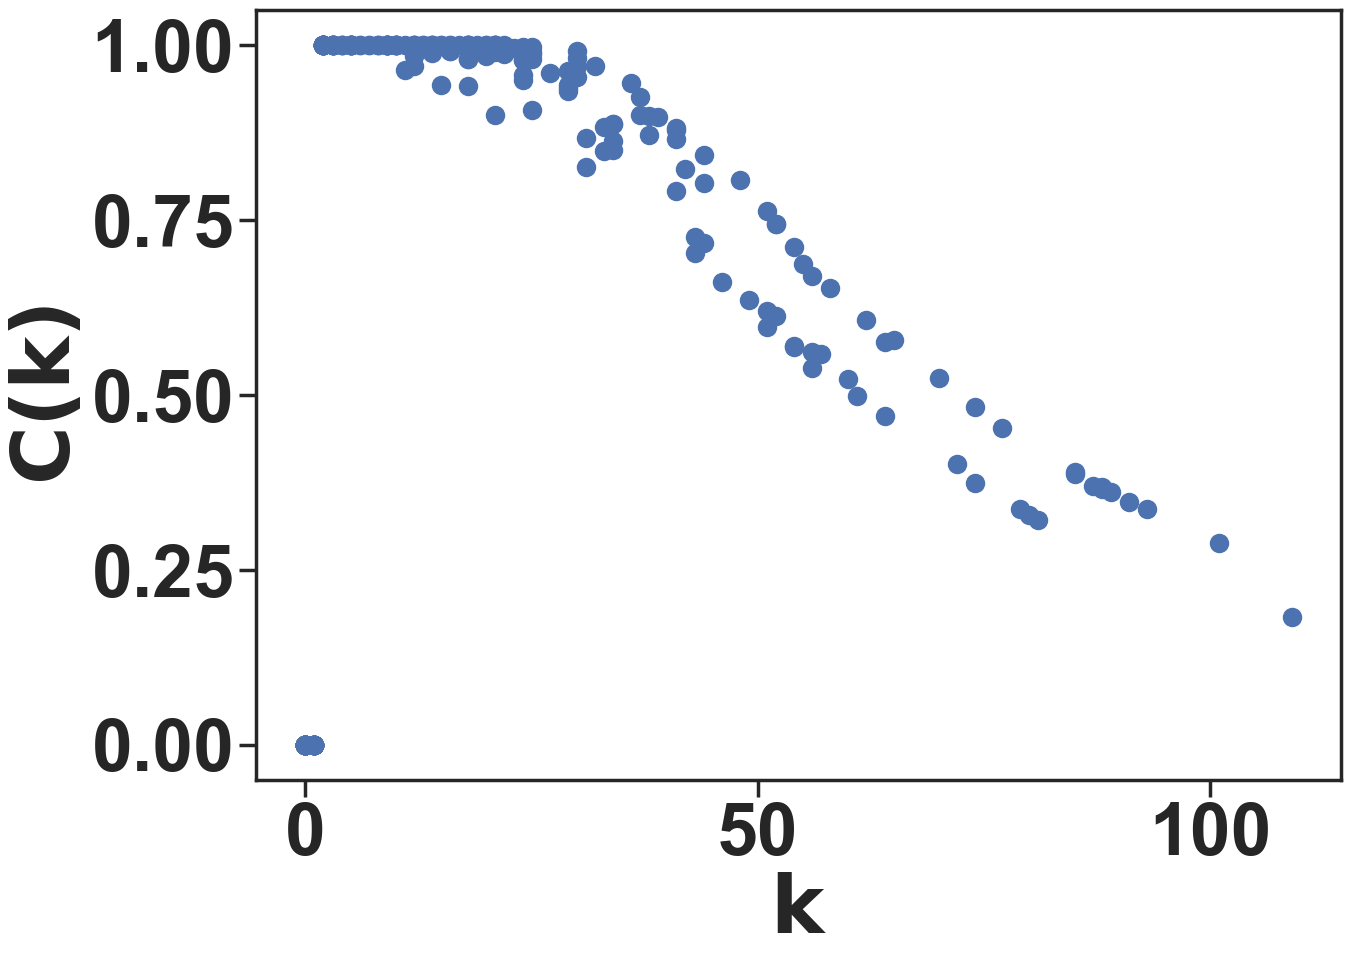

In [20]:
# IsingNet

plt.scatter(k, clustering)
plt.xlabel(r"$\bf k$")
plt.ylabel(r"$\bf C(k)$")

Text(0, 0.5, '$\\bf C(k)$')

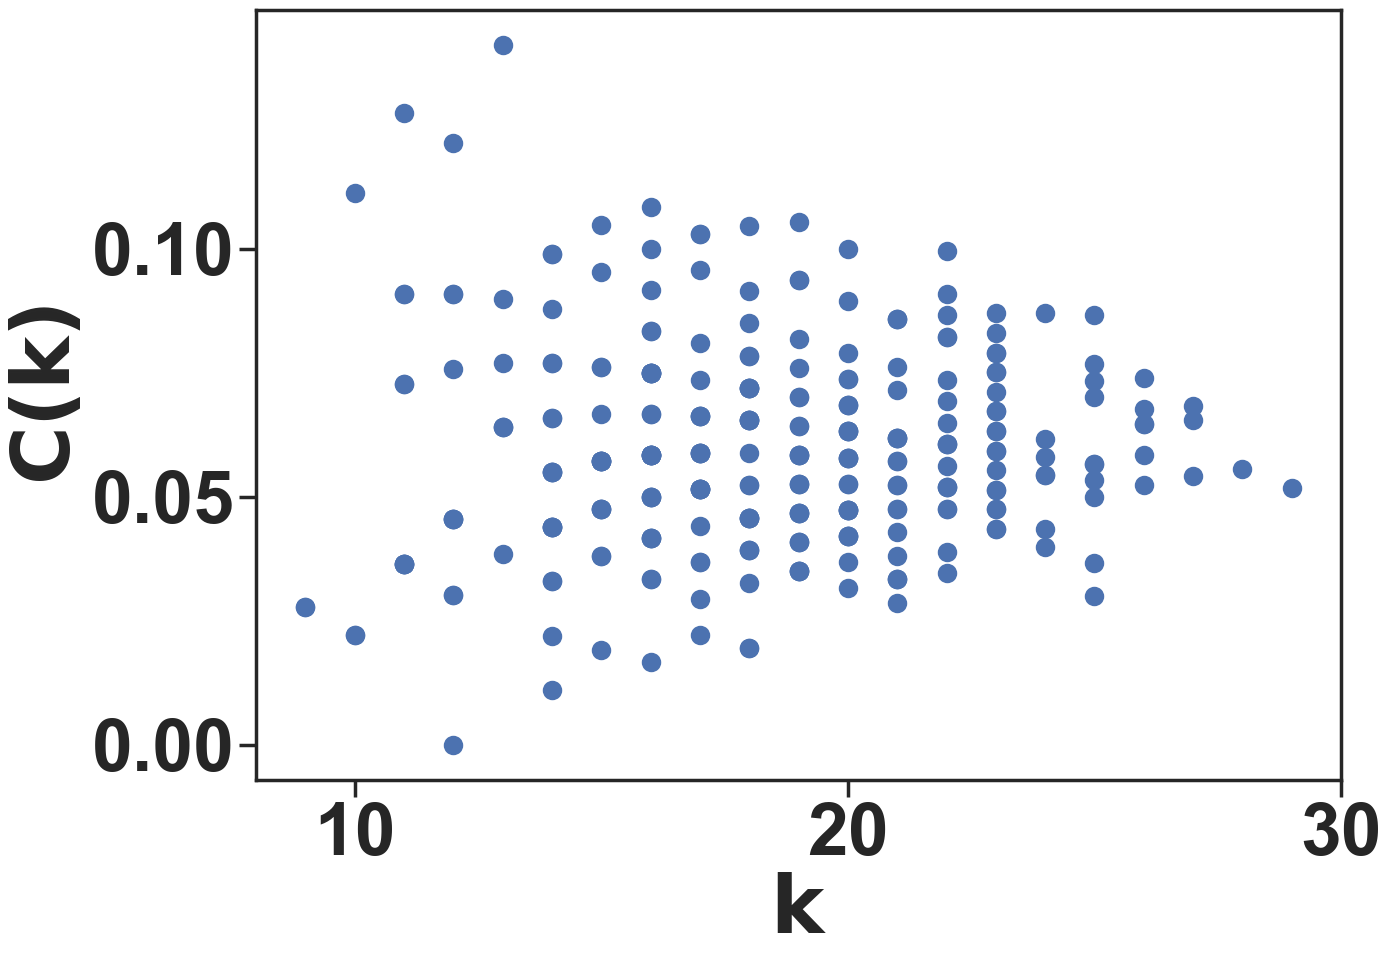

In [21]:
# Null model
plt.scatter(k_rand, clustering_rand)
plt.xlabel(r"$\bf k$")
plt.ylabel(r"$\bf C(k)$")

## Strength versus degree 

In [28]:
strength=np.array(list(G.degree(G, weight="weight")))
degree=np.array(list(G.degree(G, weight=None)))

strength_rand=np.array(list(G_rand.degree(G_rand, weight="weight")))
degree_rand=np.array(list(G_rand.degree(G_rand, weight=None)))

strength = strength/degree
strength_rand = strength_rand/degree_rand

/var/folders/vc/2r4xhqns5s325ncw9rhs184r0000gn/T/ipykernel_79946/3142217634.py:7: RuntimeWarning:

invalid value encountered in divide

/var/folders/vc/2r4xhqns5s325ncw9rhs184r0000gn/T/ipykernel_79946/3142217634.py:8: RuntimeWarning:

invalid value encountered in divide



Text(0, 0.5, '$\\bf s/k$')

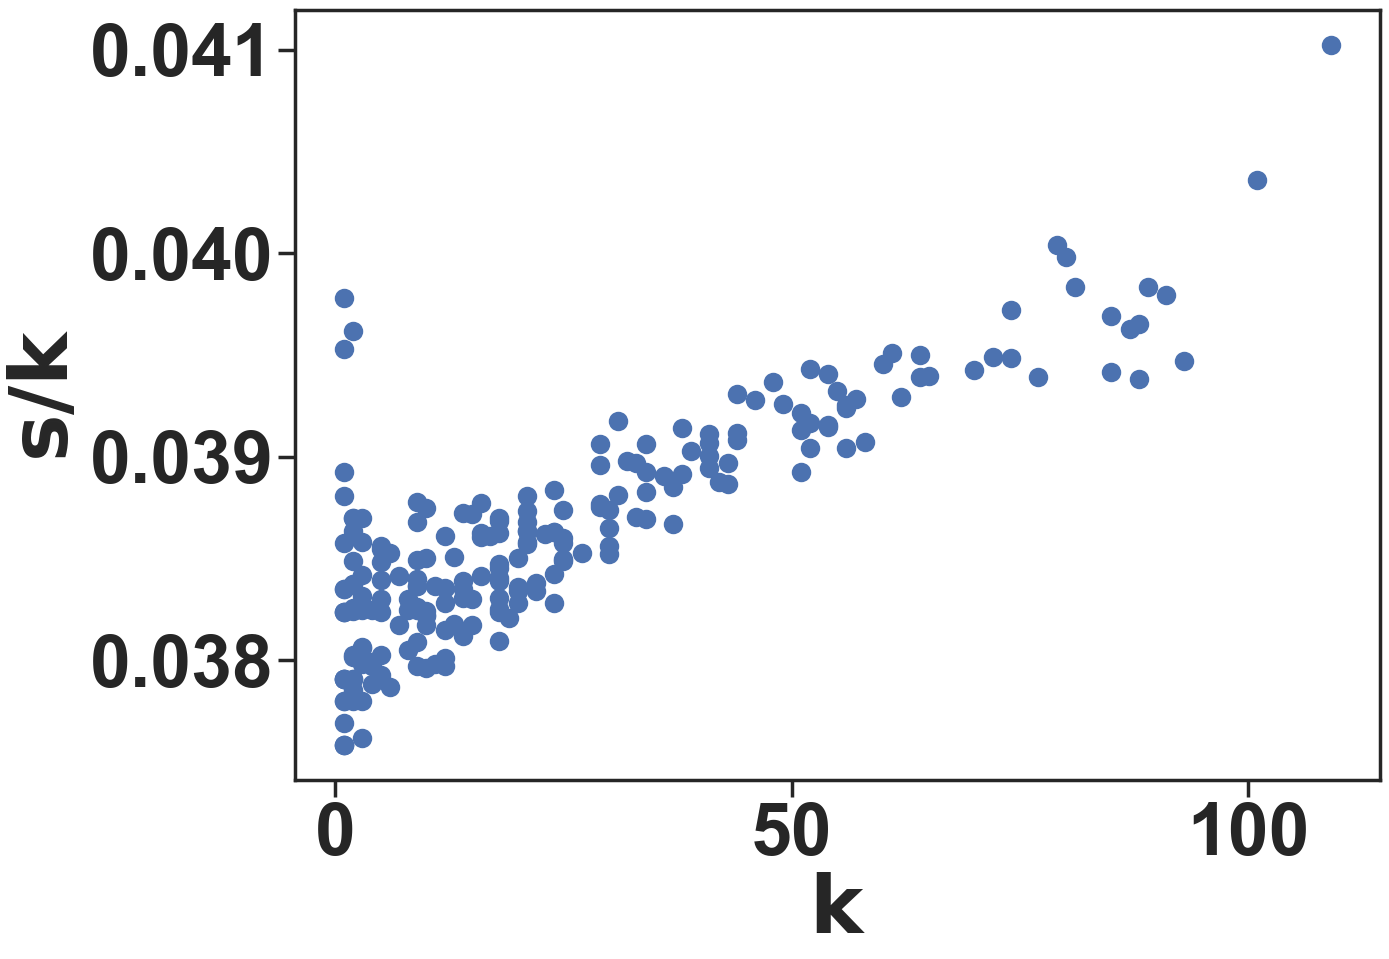

In [24]:
# IsingNet

plt.scatter(degree[:, 1], strength[:, 1])
plt.xlabel(r"$\bf k$")
plt.ylabel(r"$\bf s/k$")

Text(0, 0.5, '$\\bf s/k$')

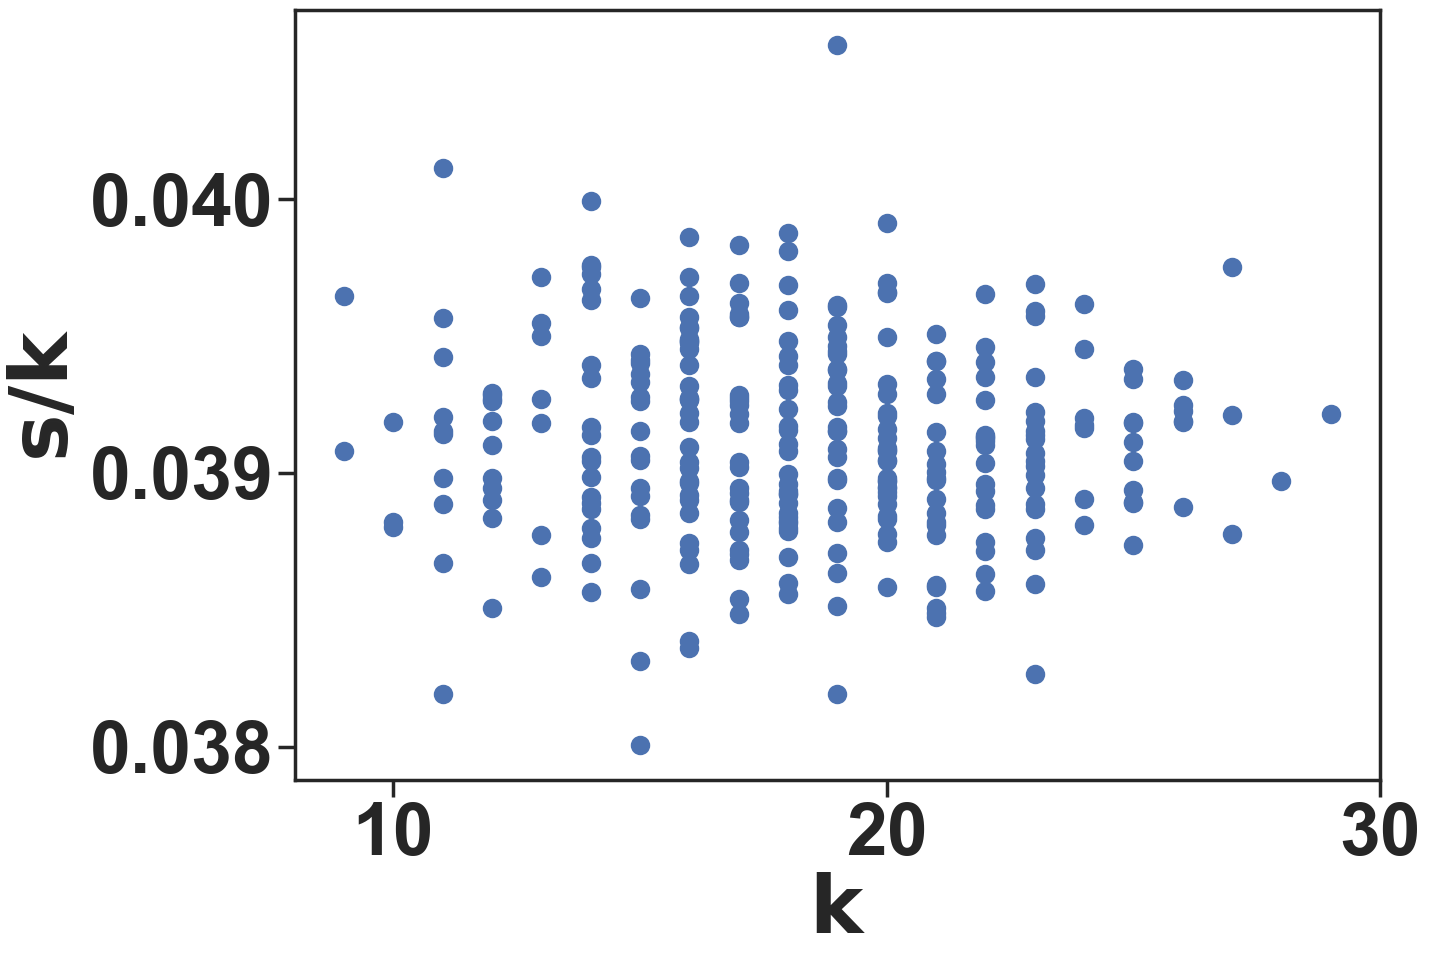

In [25]:
plt.scatter(degree_rand[:, 1], strength_rand[:, 1])
plt.xlabel(r"$\bf k$")
plt.ylabel(r"$\bf s/k$")

## Heterogeneity of neighbors: inverse participation ratio

$Y_i=\sum_j \frac{w^2_{ij}}{s_i^2}$


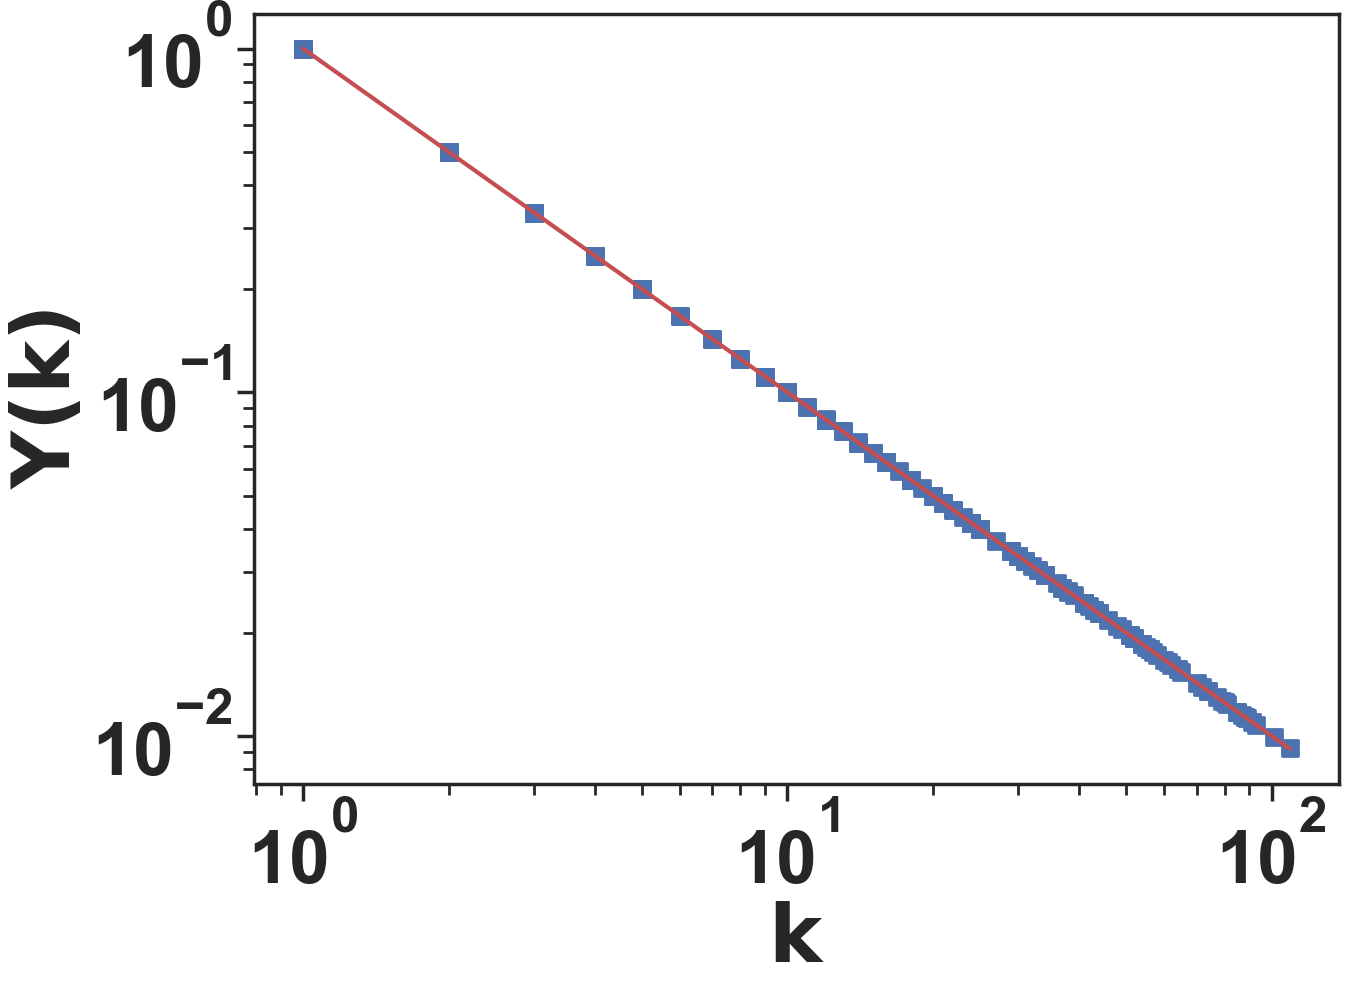

In [31]:
# This is an example of calculating inverse participation ratio (Y) for IsingNet. 
# Replace G by G_rand to obtain Y for null model.

strength=np.array(list(G.degree(G, weight="weight")))
degree=np.array(list(G.degree(G, weight=None)))

strength = strength[:, 1]
degree = degree[:, 1]

Y = np.zeros(len(G))
for node in G.nodes():

    neighbors = G.neighbors(node)
    InvPartRatio = 0
    strength_node = G.degree(node, weight="weight")

    for i in neighbors:
        InvPartRatio += (G.edges[node, i]["weight"]) ** 2
    if strength_node == 0:
        Y[node] = np.nan
    else:
        InvPartRatio = InvPartRatio / (strength_node ** 2)
        Y[node] = InvPartRatio

log_strength = np.log(strength[strength != 0])
log_degree = np.log(degree[degree != 0])

log_Y = np.log(Y[strength != 0])

slope, intercept, r, p, se = linregress(log_degree, log_Y)

x = np.linspace(1, np.max(degree), 200)
y = np.exp(intercept) * (x ** slope)

ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')

ax.scatter(degree, Y, marker='s')
plt.xlabel(r"$\bf k$")
plt.ylabel(r"$\bf Y(k)$")

ax.plot(x, y, c='r')

## Closeness its statistical properties (mean, standard deviation, skewness and kurtosis)

In [33]:
N = d.shape[0]
Cl = (N-1) * 1/sum(d)
Cl_rand = (N-1) * 1/sum(d_rand)

Cl_mean = np.mean(Cl)
Cl_std = np.std(Cl)
Cl_skew = skew(Cl)
Cl_kurtosis = kurtosis(Cl)

Cl_mean_rand = np.mean(Cl_rand)
Cl_std_rand = np.std(Cl_rand)
Cl_skew_rand = skew(Cl_rand)
Cl_kurtosis_rand = kurtosis(Cl_rand)



## Spectrum properties

### Spectrum dimension

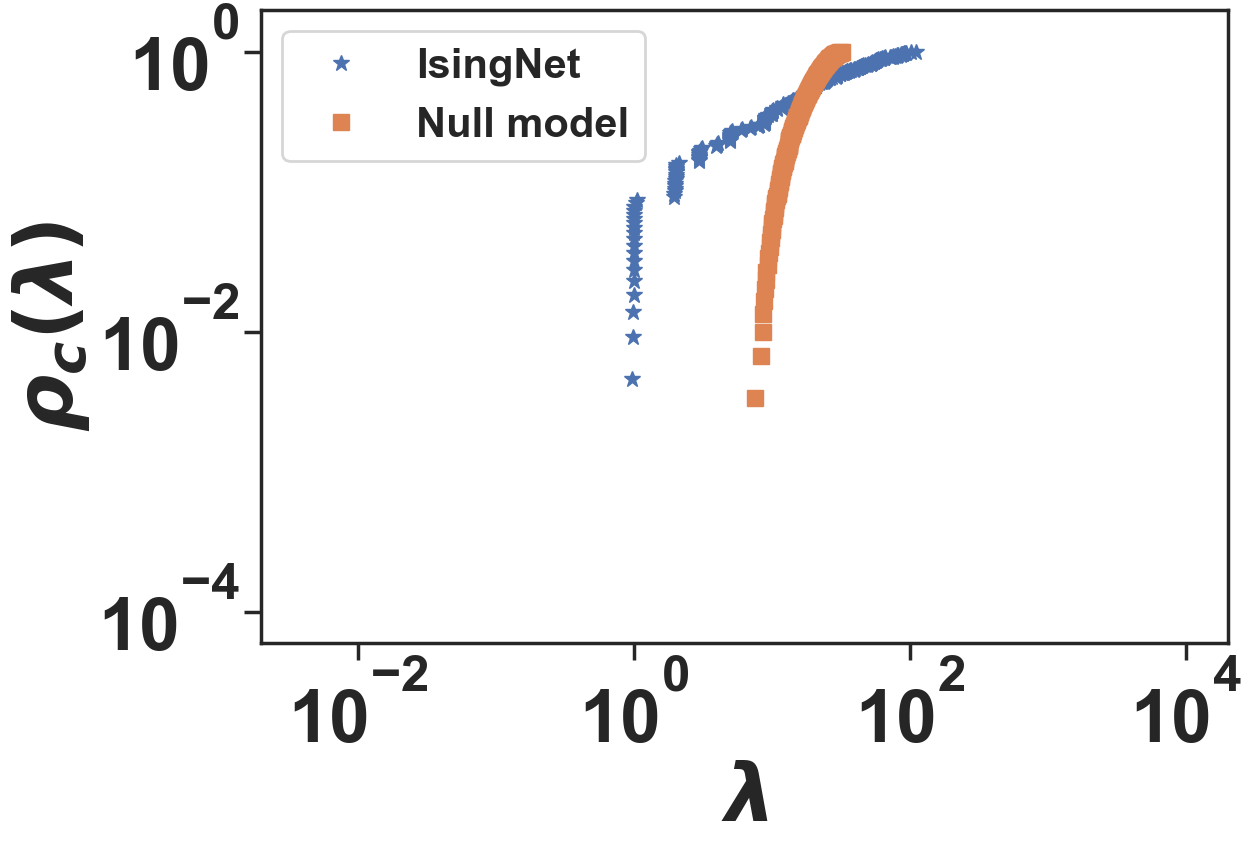

In [43]:
# Laplacian of IsingNet and null model

L = np.diag(sum(a))-a
L_rand = np.diag(sum(a_rand))-a_rand

w, v = np.linalg.eig(L)
l = np.sort(np.real(w))

w_rand, v_rand = np.linalg.eig(L_rand)
l_rand = np.sort(np.real(w_rand))

l = l[l > 10**(-10)]
N = np.max(np.shape(l))
rhoc = np.arange(N)/N

l_rand = l_rand[l_rand > 10**(-8)]
N_rand = np.max(np.shape(l_rand))
rhoc_rand = np.arange(N_rand)/N_rand



plt.loglog(l, rhoc, '*', label="IsingNet")
plt.loglog(l_rand, rhoc_rand, 's', label="Null model")

plt.xlabel('$\lambda$')
# maybe add here also legend of the temperatures for different lines
plt.ylabel(r'$\rho_c(\lambda)$')
plt.legend(fontsize=30)
plt.xlim([0.002, 20000])
label=["10^-2", "10^0", "10^2", "10^4"]
plt.xticks([0.01, 1, 100, 10000], label=label)

plt.ylim([0.00006, 2])
labely=["10^-4", "10^-2", "10^0",]
plt.yticks([0.0001, 0.01, 1], label=labely)

plt.tight_layout()

### von Neumann entropy

In [44]:
Psev=l/np.sum(l)
S_sev=-np.sum(Psev*np.log(Psev))

# Homology

In [5]:
# Persistent diagram and Betti Curve

X = [d, d_rand]
VR_comb = VietorisRipsPersistence(metric="precomputed", homology_dimensions=[0,1])
diagrams_comb = VR_comb.fit_transform(X)

BC = BettiCurve()
X_betti_curves_comb = BC.fit_transform(diagrams_comb)

In [6]:
# Persistent diagram for IsingNet
VR_comb.plot(diagrams_comb, sample=0)

In [7]:
# Persistent diagram for Null model
VR_comb.plot(diagrams_comb, sample=1)

In [8]:
# Betti curve for IsingNet
BC.plot(X_betti_curves_comb, sample=0)

In [9]:
# Betti curve for Null model
BC.plot(X_betti_curves_comb, sample=1)

In [11]:
# Distance between persistent diagrams

PD = PairwiseDistance(metric='wasserstein',
                      metric_params={'p': 2, 'delta': 0.1},
                      order=None)

# Other distance measures

'''
# PD = PairwiseDistance(metric='betti',
#                       metric_params={'p': 2, 'n_bins': 1000},
#                       order=None)

# PD = PairwiseDistance(metric='landscape',
#                       metric_params={'p': 2, 'delta': 0.1},
#                       order=None)
'''
X_distance_W = PD.fit_transform(diagrams_comb)
distance = X_distance_W[1,0,0]


54.8974573853282
